# Task 4: Gradient Conflict Analysis and Harmonization

In this task, you will explore how data heterogeneity affects the consistency of client updates in federated learning.
Specifically, you will examine how increasing heterogeneity leads to more conflicts among client updates. After
that, you will implement the Gradient Harmonization (FedGH) algorithm, which aims to address these conflicts
and improve performance in heterogeneous data scenarios. A **conflict** is defined as a situation where two updates
have an angle greater than 90 degrees, or equivalently, a negative cosine similarity. Gradient Harmonization resolves
these conflicts to ensure that client updates are better aligned, which helps mitigate the effects of data heterogeneity.
In this task, you are supposed to implement FedGH that combines FedAvg. with gradient harmonization.
Once your implementation is complete and you have compared it with FedAvg. for varying degrees of heterogeneity
levels, explore the answer to the following.
In Gradient Harmonization, adjusting conflicting gradients changes each client’s update direction from what it
originally would have been without alignment.
1. Is it guaranteed that this new, harmonized gradient direction will lead to a minimization step towards the
client’s local objective? Or could it possibly increase the local objective’s loss for some clients?
2. Consider an extreme scenario where each client’s data distribution is vastly different, causing each client to
learn a highly unique model during local training. If all clients’ gradients are heavily conflicted, how might this
affect the magnitude of the final harmonized gradient? Do you think it would be large, small, or unpredictable,
and what implications might this have on the effectiveness of the global model update?

In [ ]:
#Importing Libraries
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [ ]:
#Loading Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()

In [ ]:
#Partitioning and Creating Dataloaders
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [ ]:
#Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define the device
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define the device
    # To Do

    #//
    for round in range(rounds):
        client_updates = []
        for client_id in range(num_clients):
            local_model = SimpleCNN().to(device)  # Move the local model to the device
            local_model.load_state_dict(global_model.state_dict())
            local_update = local_train(local_model, train_loaders[client_id], epochs, lr, device)  # Pass device
            client_updates.append(local_update)

        # Average the updates
        averaged_update = {name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items()}  # Ensure tensor is on the correct device
        for client_update in client_updates:
            for name, param in averaged_update.items():
                averaged_update[name] += client_update[name].to(device) / num_clients  # Ensure client_update is on the same device

        # Update the global model
        global_model.load_state_dict(averaged_update)

        # Evaluate the model
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)
        round_avg_updates.append(averaged_update)
    #//

    return round_avg_updates, round_accuracies



def local_train(model, train_loader, epochs, lr,device):
    #//
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    #//
    #overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    overall_update = {name: torch.zeros_like(param).to(device) for name, param in model.state_dict().items()}  # Ensure tensor is on the correct device
    #To Do

    #//
    for epoch in range(epochs):
          for images, targets in train_loader:
              images, targets = images.to(device), targets.to(device)  # Move data to device
              optimizer.zero_grad()
              outputs = model(images)
              loss = F.cross_entropy(outputs, targets)
              loss.backward()
              optimizer.step()

              # Accumulate the updates
              for name, param in overall_update.items():
                  overall_update[name] += model.state_dict()[name].detach()
      #//

    return overall_update


In [ ]:
# # Parameters
# num_clients = 5
# batch_size = 128
# rounds = 3
# epochs = 20
# lr = 0.001
# dirichlet_alphas = [2, 0.5, 0.1]

# def run_fedavg(alpha):
#     train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
#     global_model_fedavg = SimpleCNN()
#     _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
#     return round_accuracies

# accuracies_per_alpha = []

# for alpha in dirichlet_alphas:
#     round_accuracies = run_fedavg(alpha)
#     accuracies_per_alpha.append(round_accuracies)


In [ ]:
# # Plotting accuracy per round for each alpha value
# plt.figure()
# for idx, alpha in enumerate(dirichlet_alphas):
#     plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

# plt.xlabel('Rounds')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
# plt.show()

In [ ]:
import builtins
sum = builtins.sum

def cosine_similarity(vec1, vec2):
    # Flatten the tensors to 1D
    vec1_flat = vec1.flatten()
    vec2_flat = vec2.flatten()
    return torch.dot(vec1_flat, vec2_flat) / (torch.norm(vec1_flat) * torch.norm(vec2_flat))

def gradient_conflict_counter(client_updates):
    total_conflicts = 0
    num_clients = len(client_updates)

    # Iterate over each layer (key) in the client updates
    for layer_name in client_updates[0].keys():
        # Collect vectors for this layer across all clients
        layer_vectors = [client_update[layer_name].view(-1).to(device) for client_update in client_updates]  # Ensure on device

        # Check pairwise cosine similarity for this layer and count conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                sim = cosine_similarity(layer_vectors[i], layer_vectors[j])
                if sim < 0:
                    total_conflicts += 1

    print(f"Total gradient conflicts detected: {total_conflicts}")
    return total_conflicts

def Federated_gradient_conflict(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    conflict_counts = []
    # To Do
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device

    for round in range(rounds):
        client_updates = []
        for client_id in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_model.state_dict())
            local_update = local_train(local_model, train_loaders[client_id], epochs, lr, device)
            client_updates.append(local_update)

        # Count conflicts
        conflicts = gradient_conflict_counter(client_updates)
        conflict_counts.append(conflicts)

        # Average the updates
        averaged_update = {name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items()}
        for client_update in client_updates:
            for name, param in averaged_update.items():
                averaged_update[name] += client_update[name].to(device) / num_clients

        # Update the global model
        global_model.load_state_dict(averaged_update)

        # Evaluate the model
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)
    #
    return round_avg_updates, round_accuracies, conflict_counts

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies,conflict_counts = Federated_gradient_conflict(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, conflict_counts

accuracies_per_alpha = []
conflicts_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies, conflict_counts = run_fedconflict(alpha)
    accuracies_per_alpha.append(round_accuracies)
    conflicts_per_alpha.append(conflict_counts)



Total gradient conflicts detected: 3

Evaluating Client 0
Client 0 Accuracy: 36.62%

Evaluating Client 1
Client 1 Accuracy: 32.83%

Evaluating Client 2
Client 2 Accuracy: 38.93%

Evaluating Client 3
Client 3 Accuracy: 44.61%

Evaluating Client 4
Client 4 Accuracy: 33.62%
Total Accuracy: 37.77%
Total gradient conflicts detected: 0

Evaluating Client 0
Client 0 Accuracy: 38.65%

Evaluating Client 1
Client 1 Accuracy: 34.50%

Evaluating Client 2
Client 2 Accuracy: 41.95%

Evaluating Client 3
Client 3 Accuracy: 46.21%

Evaluating Client 4
Client 4 Accuracy: 36.23%
Total Accuracy: 39.89%
Total gradient conflicts detected: 0

Evaluating Client 0
Client 0 Accuracy: 38.65%

Evaluating Client 1
Client 1 Accuracy: 34.54%

Evaluating Client 2
Client 2 Accuracy: 41.95%

Evaluating Client 3
Client 3 Accuracy: 46.21%

Evaluating Client 4
Client 4 Accuracy: 36.23%
Total Accuracy: 39.90%
Total gradient conflicts detected: 2

Evaluating Client 0
Client 0 Accuracy: 17.62%

Evaluating Client 1
Client 1 A

Alpha = 2, Conflicts Count: 3
Alpha = 0.5, Conflicts Count: 3
Alpha = 0.1, Conflicts Count: 3


<Figure size 1000x600 with 0 Axes>

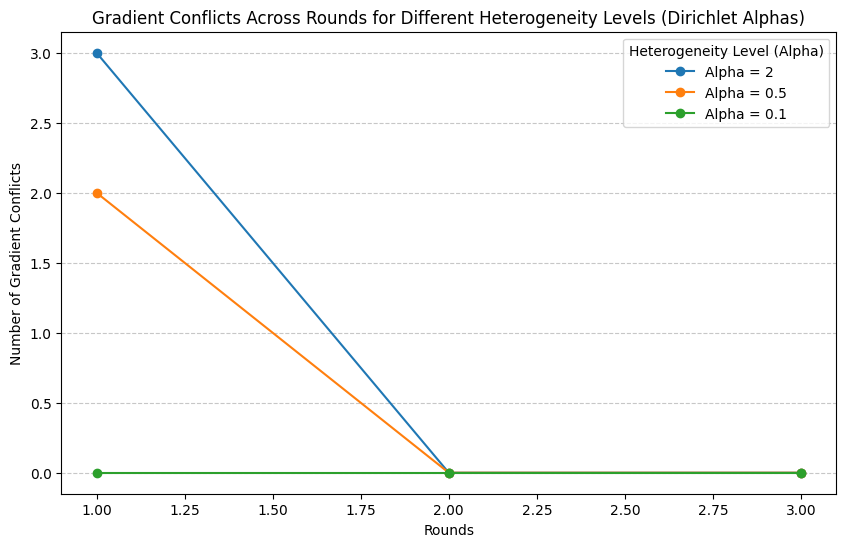

In [ ]:
plt.figure(figsize=(10, 6))

# Check the lengths of conflicts_per_alpha
for i, alpha in enumerate(dirichlet_alphas):
    print(f"Alpha = {alpha}, Conflicts Count: {len(conflicts_per_alpha[i])}")

# Plotting
plt.figure(figsize=(10, 6))
for i, alpha in enumerate(dirichlet_alphas):
    if len(conflicts_per_alpha[i]) > 0:  # Check if there are conflicts to plot
        plt.plot(range(1, rounds + 1), conflicts_per_alpha[i], marker='o', label=f'Alpha = {alpha}')
    else:
        print(f"No conflict data available for Alpha = {alpha}")

plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
def gradient_harmonization(client_updates):
    # To Do

    #//
    num_clients = len(client_updates)
    harmonized_updates = []

    for i in range(num_clients):
        harmonized_update = {name: param.clone().detach() for name, param in client_updates[i].items()}
        for j in range(num_clients):
            if i != j:
                for layer_name in client_updates[i].keys():
                    sim = cosine_similarity(client_updates[i][layer_name], client_updates[j][layer_name])
                    if sim < 0:  # Conflict detected
                        # Harmonize the gradient
                        harmonized_update[layer_name] += client_updates[j][layer_name] / 2  # Average with the conflicting update
        harmonized_updates.append(harmonized_update)

    return harmonized_updates
    #//

    # return client_updates

def Federated_gradient_harmonization(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_accuracies = []  # List to store total accuracy after each round
    pre_harmonization_conflicts = []  # List to store conflicts before harmonization
    post_harmonization_conflicts = []  # List to store conflicts after harmonization
    # To Do

    #//
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device

    for round in range(rounds):
        client_updates = []
        for client_id in range(num_clients):
            local_model = SimpleCNN().to(device)  # Move model to the device
            local_model.load_state_dict(global_model.state_dict())
            local_update = local_train(local_model, train_loaders[client_id], epochs, lr, device)  # Pass the device
            client_updates.append(local_update)

        pre_conflicts = gradient_conflict_counter(client_updates)
        pre_harmonization_conflicts.append(pre_conflicts)

        harmonized_updates = gradient_harmonization(client_updates)

        # Average the harmonized updates
        averaged_update = {name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items()}  # Ensure tensor is on the correct device
        for client_update in harmonized_updates:
            for name, param in averaged_update.items():
                averaged_update[name] += client_update[name].to(device) / num_clients  # Ensure client_update is on the same device

        # Update the global model
        global_model.load_state_dict(averaged_update)

        # Evaluate the model
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

        post_conflicts = gradient_conflict_counter(harmonized_updates)
        post_harmonization_conflicts.append(post_conflicts)

    #//

    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts


In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
alpha = 0.1

# Run federated gradient harmonization
train_loaders, test_loaders, _, _ = partition_data(
    train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size
)
global_model_fedavg = SimpleCNN()
round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = Federated_gradient_harmonization(
    global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders
)

Total gradient conflicts detected: 1

Evaluating Client 0
Client 0 Accuracy: 17.74%

Evaluating Client 1
Client 1 Accuracy: 71.29%

Evaluating Client 2
Client 2 Accuracy: 39.84%

Evaluating Client 3
Client 3 Accuracy: 21.94%

Evaluating Client 4
Client 4 Accuracy: 26.28%
Total Accuracy: 50.68%
Total gradient conflicts detected: 0
Total gradient conflicts detected: 0

Evaluating Client 0
Client 0 Accuracy: 18.36%

Evaluating Client 1
Client 1 Accuracy: 73.01%

Evaluating Client 2
Client 2 Accuracy: 41.19%

Evaluating Client 3
Client 3 Accuracy: 21.86%

Evaluating Client 4
Client 4 Accuracy: 27.55%
Total Accuracy: 51.97%
Total gradient conflicts detected: 0
Total gradient conflicts detected: 0

Evaluating Client 0
Client 0 Accuracy: 18.36%

Evaluating Client 1
Client 1 Accuracy: 73.01%

Evaluating Client 2
Client 2 Accuracy: 41.22%

Evaluating Client 3
Client 3 Accuracy: 21.86%

Evaluating Client 4
Client 4 Accuracy: 27.55%
Total Accuracy: 51.98%
Total gradient conflicts detected: 0


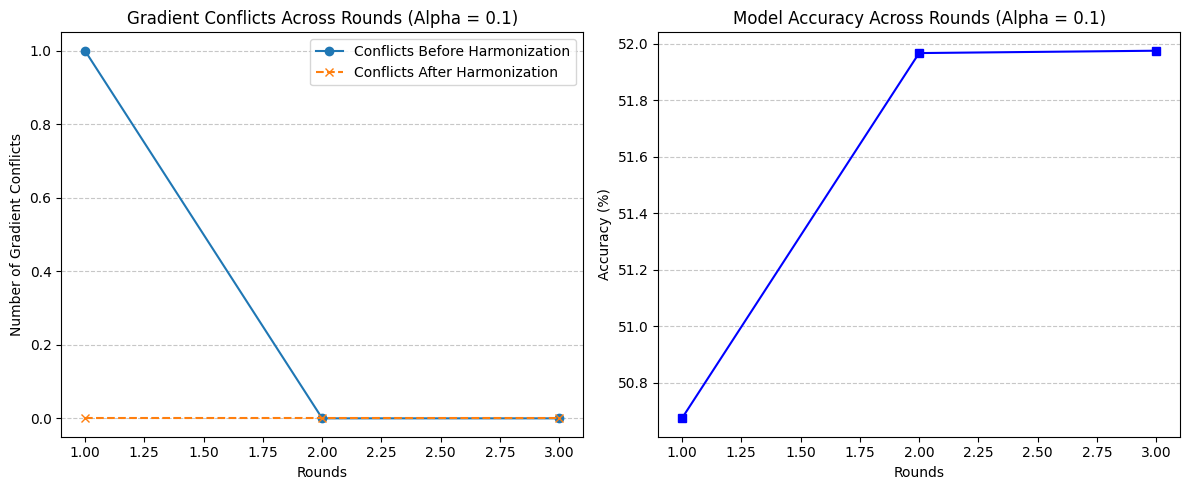

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, rounds + 1), pre_harmonization_conflicts, marker='o', linestyle='-', label='Conflicts Before Harmonization')
plt.plot(range(1, rounds + 1), post_harmonization_conflicts, marker='x', linestyle='--', label='Conflicts After Harmonization')
plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds (Alpha = 0.1)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(range(1, rounds + 1), round_accuracies, marker='s', color='b')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Across Rounds (Alpha = 0.1)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
